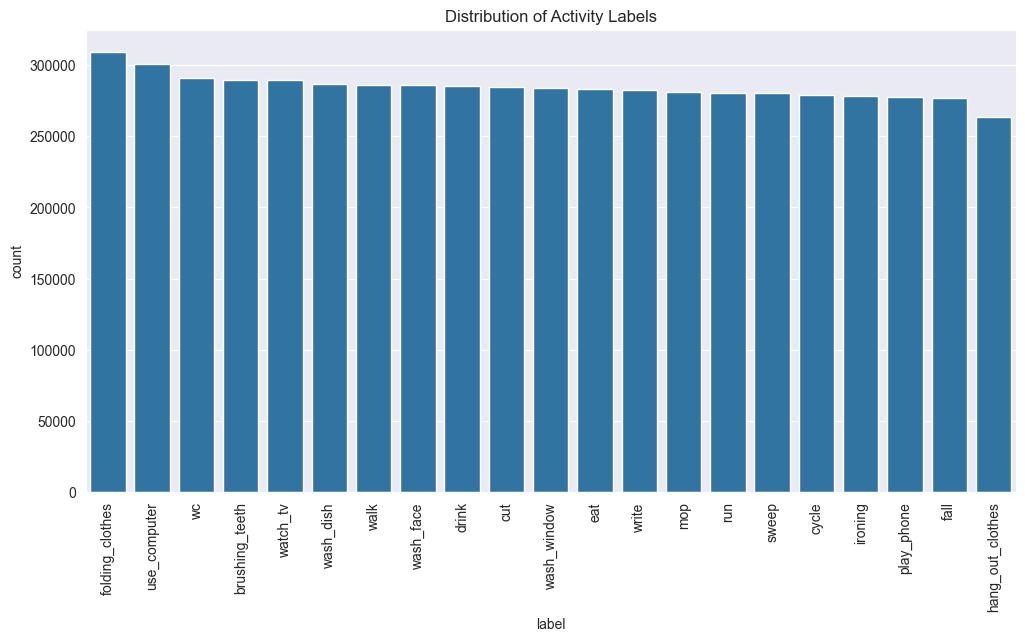

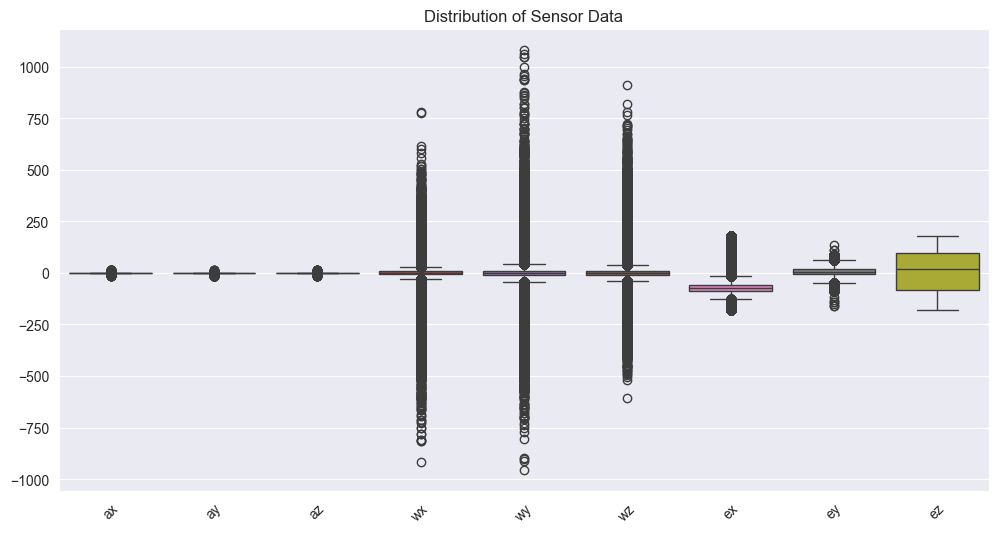

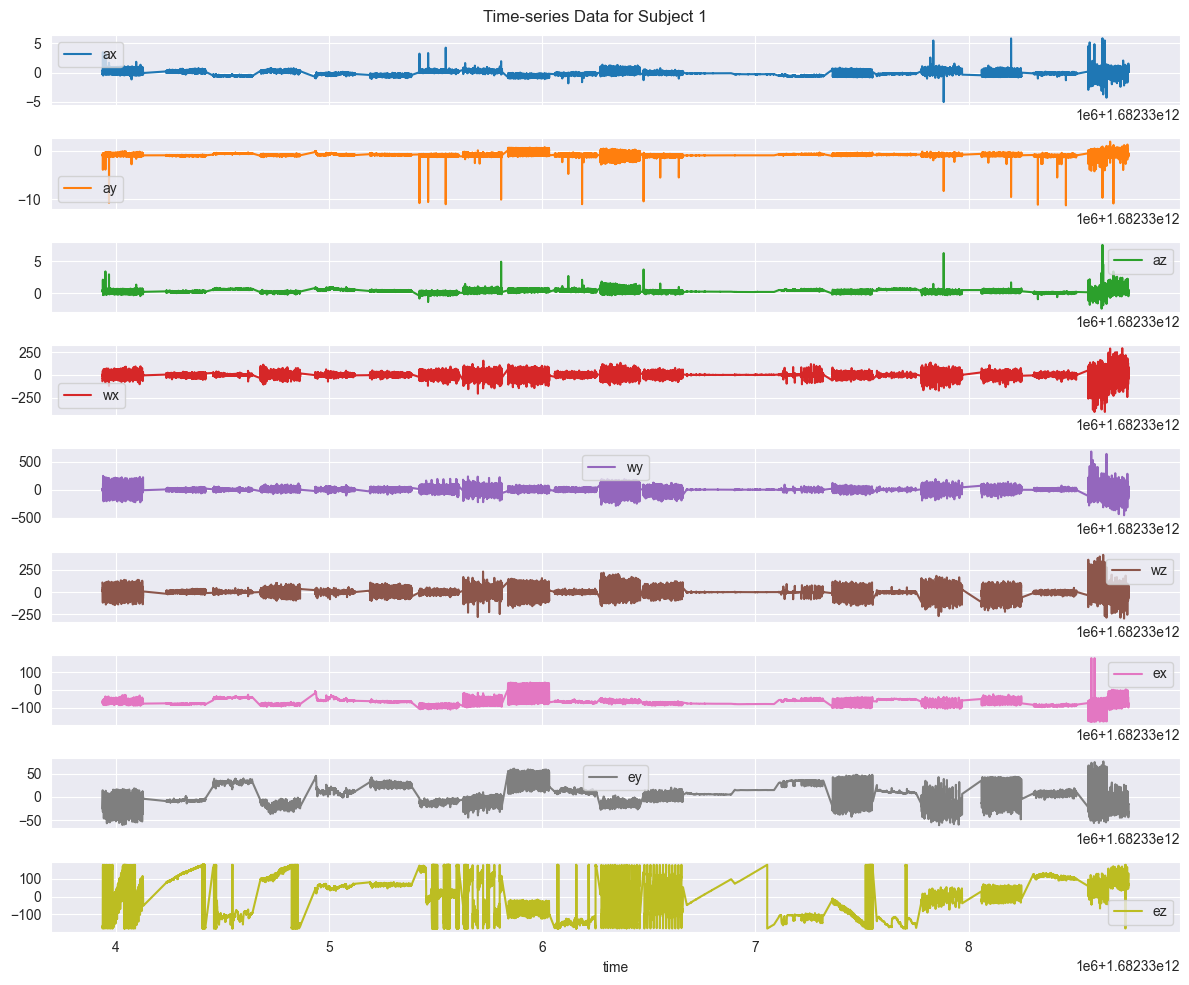

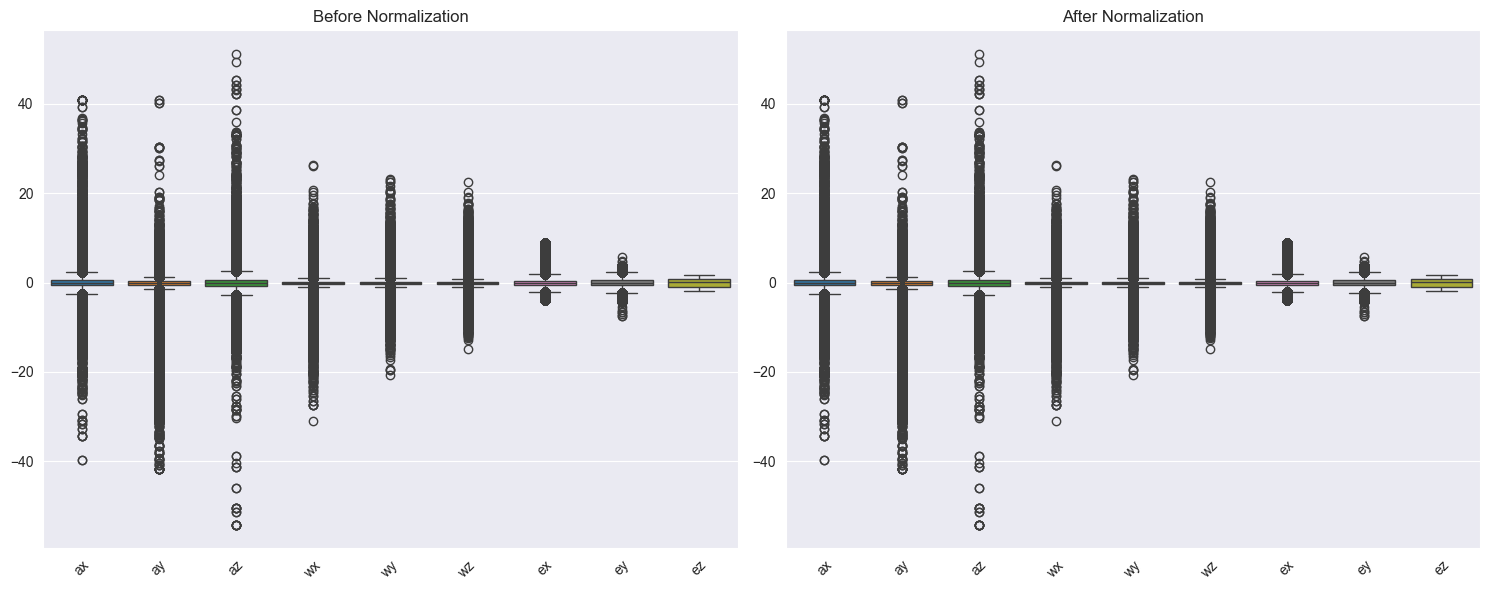

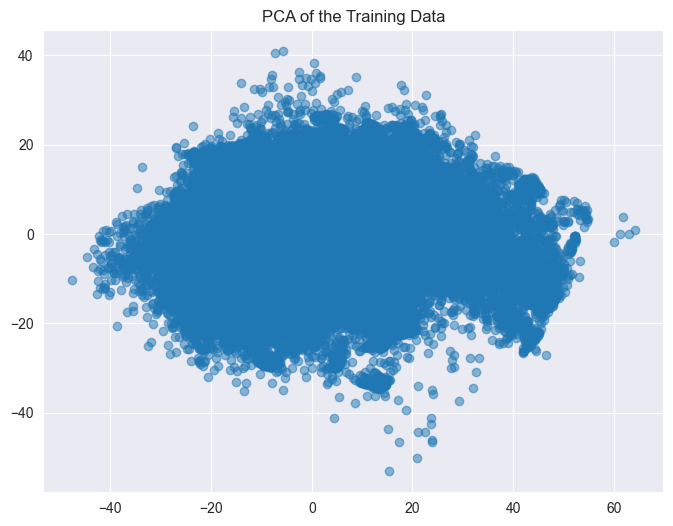

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def read_files(base_dir):
    all_data = []
    for subject_folder in os.listdir(base_dir):
        subject_path = os.path.join(base_dir, subject_folder)
        if os.path.isdir(subject_path):
            subject_number = int(subject_folder.split("_")[-1])
            for csv_file in os.listdir(subject_path):
                if csv_file.endswith("arm_r.csv"):
                    file_path = os.path.join(subject_path, csv_file)
                    df = pd.read_csv(file_path)
                    df["subject"] = subject_number
                    df["body_part"] = csv_file.split(".")[0]
                    all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def normalize_features(data):
    scaler = StandardScaler()
    columns_to_normalize = ["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    return data

def encode_labels(data):
    label_encoding = {
        "fall": 0, "run": 1, "walk": 2, "cycle": 3, "lay": 4, "squat": 5, "mop": 6, "drink": 7, "sweep": 8,
        "brushing_teeth": 9, "cut": 10, "eat": 11, "folding_clothes": 12, "hang_out_clothes": 13, "ironing": 14,
        "open_door": 15, "open_fridge": 16, "sit": 17, "stand": 18, "use_computer": 19, "wash_dish": 20,
        "wash_face": 21, "wash_window": 22, "watch_tv": 23, "watering_flowers": 24, "write": 25, "wc": 26,
        "play_phone": 27, "switch": 28
    }
    data["encoded_label"] = data["label"].map(label_encoding)
    return data

def apply_sliding_window(data, window_size=100, step_size=50):
    windows = []
    labels = []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        windows.append(window[["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]].values.flatten())
        labels.append(window["encoded_label"].mode().values[0])  # Most common label in the window
    return np.array(windows), np.array(labels)

def prepare_subject_dependent_datasets(data, train_ratio=0.8):
    X_train_all, y_train_all, X_test_all, y_test_all = [], [], [], []

    for subject in data["subject"].unique():
        subject_data = data[data["subject"] == subject].sort_values("time")
        X, y = apply_sliding_window(subject_data)

        split_idx = int(len(X) * train_ratio)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_test_all.append(X_test)
        y_test_all.append(y_test)

    return (np.vstack(X_train_all), np.concatenate(y_train_all),
            np.vstack(X_test_all), np.concatenate(y_test_all))

def save_datasets(X_train, y_train, X_test, y_test):
    np.savetxt("../Datasets/CAPP Dataset/SubjectDependent50PercentOverlap/X_train.txt", X_train)
    np.savetxt("../Datasets/CAPP Dataset/SubjectDependent50PercentOverlap/y_train.txt", y_train, fmt="%d")
    np.savetxt("../Datasets/CAPP Dataset/SubjectDependent50PercentOverlap/X_test.txt", X_test)
    np.savetxt("../Datasets/CAPP Dataset/SubjectDependent50PercentOverlap/y_test.txt", y_test, fmt="%d")

def eda(data):
    # Distribution of Classes
    plt.figure(figsize=(12, 6))
    sns.countplot(x="label", data=data, order=data["label"].value_counts().index)
    plt.title("Distribution of Activity Labels")
    plt.xticks(rotation=90)
    plt.show()
    
    # Sensor Data Statistics
    sensor_columns = ["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data[sensor_columns])
    plt.title("Distribution of Sensor Data")
    plt.xticks(rotation=45)
    plt.show()

    # Sample Time-series Plot for One Subject
    subject_sample = data[data["subject"] == data["subject"].unique()[0]]
    subject_sample.set_index("time")[sensor_columns].plot(subplots=True, figsize=(12, 10), title="Time-series Data for Subject 1")
    plt.tight_layout()
    plt.show()

def visualize_preprocessing(data, normalized_data):
    # Raw Data vs Normalized Data
    sensor_columns = ["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=data[sensor_columns])
    plt.title("Before Normalization")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.boxplot(data=normalized_data[sensor_columns])
    plt.title("After Normalization")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def pca_visualization(X_train):
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
    plt.title("PCA of the Training Data")
    plt.show()

def worker(base_dir):
    # Read and combine all data
    data = read_files(base_dir)

    # EDA before normalization
    eda(data)

    # Normalize features
    normalized_data = normalize_features(data)

    # Visualize normalization effect
    visualize_preprocessing(data, normalized_data)

    # Encode labels
    data = encode_labels(normalized_data)

    # Prepare datasets (subject-dependent)
    X_train, y_train, X_test, y_test = prepare_subject_dependent_datasets(data)

    # PCA Visualization
    pca_visualization(X_train)

    # Save datasets
    save_datasets(X_train, y_train, X_test, y_test)
    print("Subject-dependent data preprocessing completed. Datasets saved as txt files.")

base_dir = "../Datasets/CAPP Dataset/data"
worker(base_dir)